# __Value at Risk & Montecarlo Simulation__
El siguiente programa es una simulación de Montecarlo para predecir el comportamiento del futuro precio de las acciones del ETF del SPY y calcular el Valor en Riesgo al 95% de confianza.

__SIMULACIÓN DE MONTECARLO__ <br>
La simulación de montecarlo es un método computacional que repite muestreos aleatorios para obtener resultados numéricos. Se usa para simular miles de posibles trayectorias de precios basadas en la distribución histórica de los retornos.

__VALOR EN RIESGO__ <br>
El VaR (Value at Risk) es una métrica estadística que cuantifica el riesgo de pérdida de una inversión en un lapso de tiempo dado. Indica la primera pérdida máxima esperada en un horizonte temporal y nivel de confianza dados.

__RETORNOS LOGARITMICOS__ <br>
Se utilizan porque son aditivos en el tiempo y simétricos, lo que facilita el modelado y la simulación. Además, evitan que los precios simulados sean negativos.

### __Librerías__
Se utilizan las librerías:
- yfinance para descargar los datos financieros del ETF.
- Pandas para manipulación de dartos y dataframes.
- numpy para las operaciones numéricas.
- matplotlib.pypllot para graficar y visualizar los datos.

In [61]:
#IMPORTS
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### __Descargar datos históricos__
Se obtienen los precios de cierre del SPY desde hace un año a partir del día presente.

In [62]:
#BAJAR DATOS
today = pd.Timestamp.today()
start = today - pd.Timedelta(days=365)
start_date = start.strftime('%Y-%m-%d')
start_date

'2024-09-16'

In [63]:
#NUMEROS ALEATORIOS
symbol = 'SPY'
df_stock = yf.download(symbol, start=start_date, end=today.strftime('%Y-%m-%d'))[['Close']].copy()
df_stock

[*********************100%***********************]  1 of 1 completed


Price,Close
Ticker,SPY
Date,
2024-09-16,555.916016
2024-09-17,556.143188
2024-09-18,554.493774
2024-09-19,563.955872
2024-09-20,562.981018
...,...
2025-09-09,650.330017
2025-09-10,652.210022


### __Calcular retornos logaritmicos__
Se calculan los retornos logaritmicos usando la formula:<br>
retorno = Ln(Precio_t/precio_t-1)

In [64]:
#CALCULAR RETORNOS LOGARITMICOS DIARIOS
#LO VAMOS A USAR PARA FACILITAR LA SIMULACIÓN Y ESTADÍSTICA
#PARA GENERRAR SIMETRÍA EN LA DISTRIBUCIÓN. 
df_stock["returns"] = np.log(df_stock['Close'] / df_stock['Close'].shift(1))

In [65]:
df_stock

Price,Close,returns
Ticker,SPY,
Date,,
2024-09-16,555.916016,NaN
2024-09-17,556.143188,0.000409
2024-09-18,554.493774,-0.002970
2024-09-19,563.955872,0.016920
2024-09-20,562.981018,-0.001730
...,...,...
2025-09-09,650.330017,0.002309
2025-09-10,652.210022,0.002887


### __Parámetros estadísticos__
- Media (means_returns): Promedio de los retornos logarítmicos.
- Desviación estándar (std_returns): Volatilidad de los retornos.

In [66]:
#CALCULAR MEDIAS
means_returns = df_stock['returns'].mean()
#DETERMINAR DESVIACION ESTANDAR
#LA DESVIACIÓN ESTÁNDAR MIDE LA DISPERCIÓN DE UN CONJUNTO DE DATOS RESPECTO A SU PROMEDIO
std_returns = df_stock['returns'].std()
means_returns, std_returns  

(np.float64(0.000694780726116205), np.float64(0.012222903014118))

In [67]:
#1 + np.random.normal(means_returns, std_returns, 10)

### __Simulación de Montecarlo__
Genera "n" escenarios de evolución de precios sobre "n" días. Cada escenario comienza desde el último precio conocido,
Los precios futuros se simulan usando Precio_t = Precio_t-1 * (1 + ϵ) donde ϵ ∼ N(μ,σ) es un shock aleatorio obtenido de una distribución normal con la media y desviación estándar estmadas.<br>

Se devuelve una matriz de dimensiones (10000 x 30) cada row es un camino diferente que puede tomar el precio de la acción basado en los retornos logaritmicos.

In [68]:
def montecarlo_simulation(df_prices, n_simulations, n_days, mu = 0, sigma = 1):
    #INICIALZIAR LA MATRIZ DE PRECIOS SIMULADOS (10000, 30) CON CEROS
    simulated_prices = np.zeros((n_simulations, n_days))
    
    #EL PRIMER PRECIO SIMULADO ES EL ÚLTIMO PRECIO CONOCIDO
    initial_price = df_prices.iloc[-1]

    #ASIGNAR EL PRIMER VALOR DE TODAS LAS SIMULACIONES
    #A TODAS LAS FILAS Y A LA COLUMNA 0
    simulated_prices[:, 0] = initial_price

    #SIMULAR LOS PRECIOS PARA CADA DÍA Y CADA SIMULACIÓN
    for i in range(1, n_days):
        simulated_prices[:, i] = simulated_prices[:, i - 1] * (1 + np.random.normal(mu, sigma, n_simulations))
    
    return simulated_prices

In [69]:
#EJECUTAR LA SIMUACIÓN, simulas 10 caminos de 30 días cada uno
simulated_prices = montecarlo_simulation(df_stock['Close'], n_simulations=10000, n_days=30, mu=means_returns, sigma=std_returns)

df_simulated = pd.DataFrame(simulated_prices)
df_simulated

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,660.909973,662.975965,664.448289,670.156966,668.604049,663.784089,666.192833,655.024442,649.089712,662.417927,...,721.778310,730.386061,716.252391,724.618353,720.707886,722.711466,736.616331,737.001463,727.157724,722.654220
1,660.909973,667.430377,677.050664,681.805164,676.771136,669.288107,677.621262,680.460505,664.584505,656.830925,...,635.974203,616.033598,630.211023,634.015605,645.090057,641.750594,655.153544,658.417243,654.843880,669.336816
2,660.909973,671.244276,661.483161,677.106603,680.988912,685.351369,679.712847,698.846797,698.251698,699.708036,...,717.605659,696.352616,688.902422,687.825040,668.507423,658.332533,650.241245,647.147644,640.228185,652.275385
3,660.909973,657.381149,675.336072,667.323260,671.620696,666.456647,649.454126,637.641401,629.281181,627.470947,...,628.321345,633.503396,626.153751,623.911639,618.800336,622.013255,620.052036,614.136362,610.334206,610.562294
4,660.909973,661.975326,667.160100,666.392429,655.487348,657.865575,647.421683,651.100584,658.650626,666.265985,...,664.445791,665.689398,682.021288,679.474906,677.820599,659.262238,657.575898,636.903660,618.874831,625.039172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,660.909973,651.590074,665.710995,677.159872,664.729145,661.738253,663.383020,664.235232,655.606314,648.584720,...,618.463589,618.637883,615.436449,606.805250,621.220149,625.429679,628.301775,635.553104,643.983008,633.276581
9996,660.909973,665.905874,665.774784,658.157259,646.007007,634.758816,626.765994,640.177723,636.490193,641.751472,...,632.830928,627.089740,625.611108,641.942118,631.322158,628.923679,641.270776,646.539529,645.910314,645.146980
9997,660.909973,661.576620,668.795599,668.601125,668.067231,674.999340,675.629337,672.275875,673.730490,674.557880,...,659.404757,667.409802,670.894429,664.053110,669.706353,669.613829,672.320872,667.501828,681.220984,662.716314
9998,660.909973,662.619935,654.730941,653.034348,660.618129,665.654257,676.867252,677.804283,666.242191,678.449310,...,717.032352,713.617273,715.799083,726.747041,734.806076,733.857611,728.512853,736.935748,726.085084,736.025541


### __Métricas de Riesgo__
Se calcula el valor esperado, que es la media de los precios simulados en el día 30.

También se calcula el Valor en Riesgo (Value at Risk - VaR) al 95%, aplanando la matriz de precios simulados para tomar en cuenta todos los escenarios y el VaR al 95% es el percentil 5 de la distribución de precios (pérdida máxima con 95% de confianza)

In [70]:
#PERCENTILES Y RANGOS DE CONFIANZA
percentil_2_5 = np.percentile(simulated_prices[:,-1], 2.5, axis=0)
percentil_97_5 = np.percentile(simulated_prices[:,-1], 97.5, axis=0)

print(f'95% de confianza que el precio de cierre en 30 días estará entre {percentil_2_5:.2f} y {percentil_97_5:.2f}')

95% de confianza que el precio de cierre en 30 días estará entre 591.41 y 766.24


In [71]:
#VALOR ESPERADO
expected_price = np.mean(simulated_prices[:, -1])
print(f'El valor esperado del precio de cierre en 30 días es {expected_price:.2f}')

El valor esperado del precio de cierre en 30 días es 674.56


In [ ]:
#CÁLCULO DE VAR
confiance_interval = 0.95
simulated_prices_flat = df_simulated.values.flatten()
VaR = np.percentile(simulated_prices_flat, 100 * (1 - confiance_interval))
print(f'El VaR al {confiance_interval * 100:.0f} es {VaR:.2f}')

El VaR al 95 es 618.81


### __Visualización de los resultadps__
Se grafica un histograma de todos los precios simulados y se traza una línea vertical roja que indica el VaR calculado. También se agregan otras graficas.

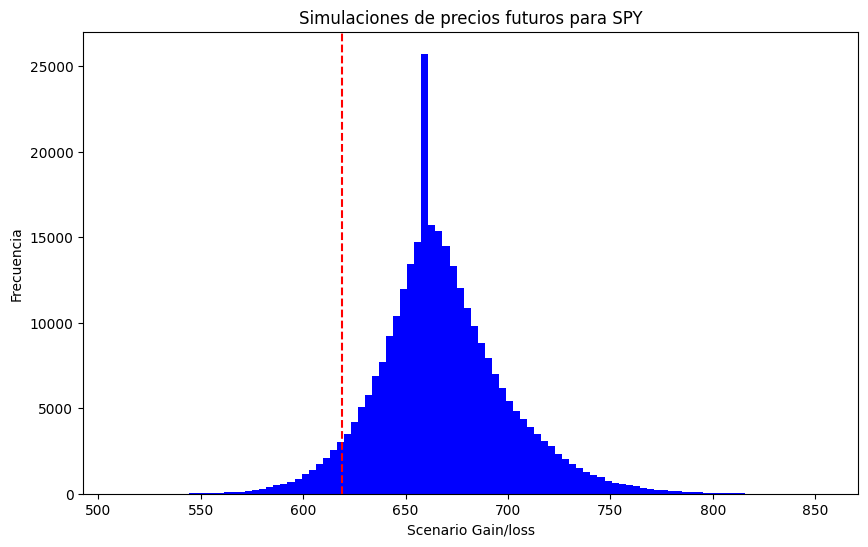

In [73]:
#MOSTRAR GRAFICA
plt.figure(figsize=(10,6))
plt.hist(simulated_prices_flat.T, bins = 100, color='blue')
plt.title(f'Simulaciones de precios futuros para {symbol}')
plt.xlabel('Scenario Gain/loss')
plt.ylabel('Frecuencia')
plt.axvline(x=VaR, color='red', linestyle='--', label=f'VaR {confiance_interval*100:.0f}%: {VaR:.2f}')
plt.show()

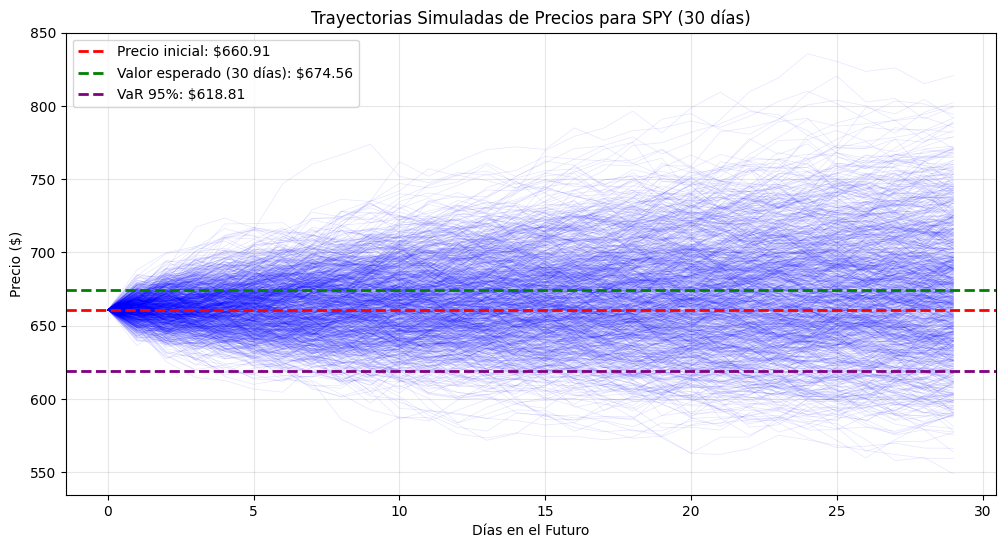

In [74]:
#GRAFICAR MUESTRA DE LOS CAMINOS SIMULADOS
plt.figure(figsize=(12,6))

#SELECCIONAR UNA MUESTRA ALEATORIA DE LAS SIMULACIONES PARA GRAFICAR
trayectorias = 1000
n_simulations = 10000
indices_aleatorios = np.random.choice(n_simulations, trayectorias, replace=False)

#GRAFICAR CADA TRAYECTORIA SELECCIONADA
for i in indices_aleatorios:
    plt.plot(df_simulated.iloc[i], color='blue', alpha=0.1, linewidth=0.5)

# GRAFICAR PRECIO INICIAL
initial_price = df_simulated.iloc[0, 0]
plt.axhline(y=initial_price, color='red', linestyle='--', linewidth=2, label=f'Precio inicial: ${initial_price:.2f}')

# GRAFICAR PRECIO FINAL
plt.axhline(y=expected_price, color='green', linestyle='--', linewidth=2, 
            label=f'Valor esperado (30 días): ${expected_price:.2f}')

# Graficar el VaR
plt.axhline(y=VaR, color='purple', linestyle='--', linewidth=2, 
            label=f'VaR 95%: ${VaR:.2f}')

plt.title(f'Trayectorias Simuladas de Precios para {symbol} (30 días)')
plt.xlabel('Días en el Futuro')
plt.ylabel('Precio ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### __INTERPRETACIÓN__
Importante aclarar que los resultados escritos en esta interpretación fueron los resultados obtenidos de la ejecución de la simulación. Si se vuelve a correr el notebook, los resultados cambiarán un poco con los aquí reportados.
- El valor esperado en 30 días es de $674.56
- El Valor en Riesgo al 95% es de $618.81

Con un 95% de confianza, la pérdida máxma en 30 días no superará los $42.1 por acción. ($660.91 - $618.81)

Para un inversor promedio del SPY, estos numeros son positivos ya que muestran que hay mpas probabilidad de ganancia, la pérdida máxima es limitada y predecible y el riesgo/beneficio es equilibrado.